In [1]:
!pip install rasterio==1.3.9

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 32.1 MB/s eta 0:00:0000:0100:01


In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
import json
import matplotlib.pyplot as plt
import folium

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

"""# Model Building
import ultralytics
from ultralytics import YOLO
import labelme2yolo"""

# Others
import os
import shutil
import zipfile

from tqdm import tqdm
import glob

## Create a dataset of building footprint segmentation masks. 

with S3 credential and SSP Cloud access : 
- mc cp s3/mbesnier/damage_detection/building_footprints_puerto_rico ./ --recursive 

Task Description : 
- [x] Finding the corresponding files containing the building footprints in Puerto Rico
- [x] Extracting the footprints with geolocated information
- [x] Associate the titles from the data processing of Puerto Rico (images from tiff files) to the geolocalized masks. (use a KD tree) (for each retrieved footprint find the closest title centroid )
- [ ] Transform the building footprint into a segmentation mask for semantic segmentation instance. 
- [ ] Build the dataset: image/masks => Train/Eval/Test dataset
- [ ] Train a Building detector (use **Active learning** to know which extra data should be annotated. )
- [ ] Apply some technics from conformal prediction to evaluate Classifier and Segmentation model.   
- [ ] Train an **Image segmentation** Building Footprint detector (with and without extra classes => See the transfer learning possibilities).

In [3]:
list_paths = glob.glob("/home/onyxia/work/building_footprints_puerto_rico/*.csv") #put the files of footprint
print(len(list_paths))

7


In [4]:
def safe_json_loads(data):
    try:
        return json.loads(data)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        print("line : ", data)
        return None

In [5]:
#put the files of footprint
import json

# reading the data from the file
json_objects = []
for path in list_paths:
      print("processing " + str(path)) 
      with open(path) as f:
          data = f.read()
  # reconstructing the data as a dictionary
      json_objects.extend([safe_json_loads(line) for line in data.strip().split('\n')])

processing /home/onyxia/work/building_footprints_puerto_rico/part-00047-4c7e08f3-c962-4e99-bede-6337b2eedfdc.csv
Error decoding JSON: Expecting value: line 1 column 9 (char 8)
line :  {"type":
processing /home/onyxia/work/building_footprints_puerto_rico/part-00021-4c7e08f3-c962-4e99-bede-6337b2eedfdc.csv
processing /home/onyxia/work/building_footprints_puerto_rico/part-00199-4c7e08f3-c962-4e99-bede-6337b2eedfdc.csv
processing /home/onyxia/work/building_footprints_puerto_rico/part-00007-4c7e08f3-c962-4e99-bede-6337b2eedfdc.c000.csv


processing /home/onyxia/work/building_footprints_puerto_rico/part-00006-4c7e08f3-c962-4e99-bede-6337b2eedfdc.csv
Error decoding JSON: Unterminated string starting at: line 1 column 2 (char 1)
line :  {"t
processing /home/onyxia/work/building_footprints_puerto_rico/part-00059-4c7e08f3-c962-4e99-bede-6337b2eedfdc.csv
processing /home/onyxia/work/building_footprints_puerto_rico/part-00167-4c7e08f3-c962-4e99-bede-6337b2eedfdc.csv


In [6]:
len(json_objects)

580868

In [7]:
import pandas as pd
from shapely.geometry import Polygon

parsed_data = [Polygon(item['geometry']['coordinates'][0]) for item in json_objects if item is not None ]
gdf = gpd.GeoDataFrame(data=parsed_data, columns=['geometry'])
gdf.set_crs("EPSG:4326", inplace=True)

,geometry
0,"POLYGON ((-65.41835 18.15180, -65.41842 18.151..."
1,"POLYGON ((-65.42526 18.14796, -65.42512 18.147..."
2,"POLYGON ((-65.42520 18.14417, -65.42512 18.144..."
3,"POLYGON ((-65.42657 18.14126, -65.42660 18.141..."
4,"POLYGON ((-65.42566 18.14197, -65.42571 18.141..."
...,...
580861,"POLYGON ((-65.30569 18.31066, -65.30568 18.310..."
580862,"POLYGON ((-65.30040 18.31938, -65.30037 18.319..."
580863,"POLYGON ((-65.30253 18.31452, -65.30252 18.314..."
580864,"POLYGON ((-65.30736 18.31383, -65.30744 18.313..."


### Test

In [18]:
import random
gdf = gdf.sample(n=1000, random_state=42)

In [19]:
gdf.geometry.to_crs("4326")
centroid = gdf.geometry.centroid #centroids of the bulding footprints. 
center =  [centroid.y.mean(), centroid.x.mean()]
map = folium.Map(location=center, zoom_start=8) #Microsoft use this geodesic referential : EPSG: 4326 (correspond to GPS)

### Access to EY Challenge Data (Pre event and Post event San Juan catastrophy)

In [ ]:
!mc cp s3/mbesnier/damage_detection/raw_data . --recursive  #load the data from the S3 bucket

In [22]:
# load the data from API 
!wget "https://challenge.ey.com/api/v1/storage/admin-files/Pre_Event_San_Juan.tif" -O "Pre_Event_San_Juan.tif"
!wget "https://challenge.ey.com/api/v1/storage/admin-files/Post_Event_San_Juan.tif" -O "Post_Event_San_Juan.tif"

--2024-05-20 17:12:22--  https://challenge.ey.com/api/v1/storage/admin-files/Pre_Event_San_Juan.tif
Resolving challenge.ey.com (challenge.ey.com)... 52.236.158.32
Connecting to challenge.ey.com (challenge.ey.com)|52.236.158.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1016993213 (970M) [application/octet-stream]
Saving to: ‘Pre_Event_San_Juan.tif’

Pre_Event_San_Juan. 100%[===================>] 969.88M  63.5MB/s    in 16s     

2024-05-20 17:12:49 (62.6 MB/s) - ‘Pre_Event_San_Juan.tif’ saved [1016993213/1016993213]

--2024-05-20 17:12:49--  https://challenge.ey.com/api/v1/storage/admin-files/Post_Event_San_Juan.tif
Resolving challenge.ey.com (challenge.ey.com)... 52.236.158.32
Connecting to challenge.ey.com (challenge.ey.com)|52.236.158.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1310494499 (1.2G) [application/octet-stream]
Saving to: ‘Post_Event_San_Juan.tif’

Post_Event_San_Juan 100%[===================>]   1.22G  59.4M

In [44]:
pre_event_image = './Pre_Event_San_Juan.tif'

In [10]:
gdf.bounds.head()

,minx,miny,maxx,maxy
0,-65.418577,18.151710,-65.418351,18.151913
1,-65.425258,18.147914,-65.425068,18.148098
2,-65.425200,18.144165,-65.425115,18.144236
3,-65.426663,18.141179,-65.426568,18.141285
4,-65.425706,18.141926,-65.425656,18.141970


### Generate Tiles from raw tiff pictures

In [6]:
def generate_tiles(input_file, output_dir,grid_x,grid_y):
    ds = gdal.Open(input_file)

    # Get image size and number of bands
    width = ds.RasterXSize
    height = ds.RasterYSize
    num_bands = ds.RasterCount

    # Calculate number of tiles in each dimension
    num_tiles_x = (width // grid_x)
    num_tiles_y = (height // grid_y)

    print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each tile and save as a separate TIFF image
    for i in tqdm(range(num_tiles_x)):
        for j in range(num_tiles_y):
            x_offset = i *  grid_x
            y_offset = j *  grid_y

            tile_width = min(grid_x, width - x_offset)
            tile_height = min(grid_y, height - y_offset)

            tile = []
            for band in range(1, num_bands + 1):
                tile_data = ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
                tile.append(tile_data)

            # Create output filename
            output_file = os.path.join(output_dir, f"tile_{i}_{j}.tif")

            # Create an output TIFF file with same CRS and band values range
            driver = gdal.GetDriverByName("GTiff")
            options = ['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES']
            out_ds = driver.Create(output_file, tile_width, tile_height, num_bands,
                       ds.GetRasterBand(1).DataType, options=options)
            # out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, ds.GetRasterBand(1).DataType)

            # Set the geotransform
            geotransform = list(ds.GetGeoTransform())
            geotransform[0] = geotransform[0] + x_offset * geotransform[1]
            geotransform[3] = geotransform[3] + y_offset * geotransform[5]
            out_ds.SetGeoTransform(tuple(geotransform))

            # Set the projection
            out_ds.SetProjection(ds.GetProjection())

            # Write each band to the output file
            for band in range(1, num_bands + 1):
                out_band = out_ds.GetRasterBand(band)
                out_band.WriteArray(tile[band - 1])

            # Close the output file
            out_ds = None

    print("Tiles generation completed.")

In [ ]:
input_file = "Post_Event_San_Juan.tif"
output_dir = "./Post_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512
generate_tiles(input_file, output_dir, grid_x, grid_y)

In [53]:
input_file = "Pre_Event_San_Juan.tif"
output_dir = "./Pre_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512
generate_tiles(input_file, output_dir, grid_x, grid_y)

Total number of tiles: 10730


100%|██████████| 74/74 [07:40<00:00,  6.22s/it]

Tiles generation completed.


In [8]:
# Open the geotiff file
import re 
def extract_title_ij(filename):
    pattern = r"(\w+)/tile_(\d+)_(\d+).tif"
    match = re.search(pattern, filename)
    if match:
        title , i, j = map(str, match.groups())
        return title, i, j
    else:
        return None, None, None


def load_and_visualize(image_path):
    """
    display a tif image (little tiles are recommended)
    """
    with rasterio.open(image_path) as src:
        # Read the red, green, and blue bands directly into a 3D array
        image_rgb = src.read([1, 2, 3])  # Read bands 1, 2, and 3 in a single call
        # Transpose the array for correct display (optional)
        image_rgb = image_rgb.transpose(1, 2, 0)

        title , i, j = extract_title_ij(image_path)

        # Display the RGB composite image
        plt.imshow(image_rgb)
        plt.title(f"Image from {title} at position (i={i},j={j})")
        plt.show()

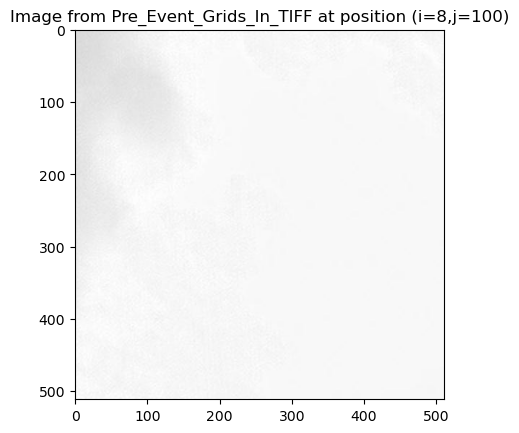

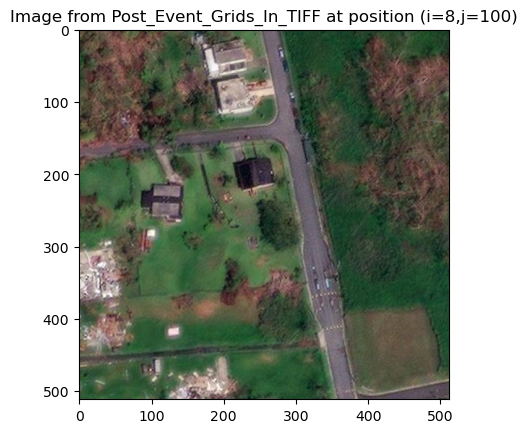

In [9]:
i = 8 
j = 100

load_and_visualize(f"Pre_Event_Grids_In_TIFF/tile_{i}_{j}.tif")
load_and_visualize(f"Post_Event_Grids_In_TIFF/tile_{i}_{j}.tif")

In [10]:
import shapely.geometry
import rasterio.features 

def extract_coor_from_tiff_image(path):
  """
  extract coordinates associated to a tif image
  """
  with rasterio.open(path) as dataset:

    # Read the dataset's valid data mask as a ndarray.

    mask = dataset.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):
        
        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

        bounds = shapely.geometry.shape(geom).bounds
        #minx, miny, maxx, maxy = bounds
        bounds = [[bounds[1], bounds[0]], [bounds[3], bounds[2]]]
        #[[18.461885, -66.190829], [18.463317, -66.189328]]

        return geom, bounds # return a geojson object (polygon localized on a map)
        #bounds are folium compatible

def convert_tiff_to_numpy(tif_path):
    # check if output_dir exists, if not create it
    # check if file is an image (ends with .tif)
    with rasterio.open(tif_path)as src:
          image_array = src.read([1, 2, 3])  # Read bands 1, 2, and 3 in a single call
          # Transpose the array for correct display (optional)
          image_array = image_array.transpose(1, 2, 0)
          return image_array    


In [11]:
extract_coor_from_tiff_image("Pre_Event_Grids_In_TIFF/tile_9_86.tif")

({'type': 'Polygon',
  'coordinates': [[[-66.179205, 18.358742],
    [-66.179228, 18.357332],
    [-66.177751, 18.35731],
    [-66.177728, 18.35872],
    [-66.179205, 18.358742]]]},
 [[18.35731, -66.179228], [18.358742, -66.177728]])

In [12]:
import multiprocessing as mp
from joblib import Parallel, delayed

def process_tif(path):
    geom , bounds = extract_coor_from_tiff_image(path)
    geom = Polygon(geom["coordinates"][0])
    return [path, geom]

def table_tiff_geojson_fast(folder_tiff):
    """
    create a geo dataframe from a tiff folder
    """
    if os.path.exists(folder_tiff):
        list_tifs = glob.glob(folder_tiff + "/*.tif")
        gdf = gpd.GeoDataFrame(columns=["path", "geometry"], index=range(len(list_tifs)))

        num_cores = mp.cpu_count()  # Number of cores in your machine
        print("number of cores : ", num_cores)
        results = Parallel(n_jobs=num_cores)(delayed(process_tif)(path) for path in list_tifs)

        for i, result in enumerate(results):
            gdf.loc[i] = result

        print(f"{folder_tiff} has been converted into GeoJSON DataFrame")
        return gdf

In [20]:
def table_tiff_geojson(folder_tiff):
    """
    create a geo dataframe from a tiff folder
    """
    if os.path.exists(folder_tiff):
      list_tifs = glob.glob(folder_tiff + "/*.tif")

      gdf = gpd.GeoDataFrame(columns=["path", "geometry"])
      for i, path in tqdm(enumerate(list_tifs)):
        geom , bounds = extract_coor_from_tiff_image(path)
        geom = Polygon(geom["coordinates"][0])
        gdf.loc[len(gdf)] = [list_tifs[i], geom] #geom ESPG 4326
    print(f"{folder_tiff} has been converted into GeoJSON DataFrame")
    return gdf

In [13]:
%%time
folder_tiff = "Pre_Event_Grids_In_TIFF"
table_tiff_pre = table_tiff_geojson_fast(folder_tiff) #table_tiff_geojson(folder_tiff)

number of cores :  104


Pre_Event_Grids_In_TIFF has been converted into GeoJSON DataFrame
CPU times: user 18.5 s, sys: 6.67 s, total: 25.1 s
Wall time: 27.7 s


In [14]:
%%time
folder_tiff = "Post_Event_Grids_In_TIFF"
table_tiff_post = table_tiff_geojson_fast(folder_tiff)

number of cores :  104


Post_Event_Grids_In_TIFF has been converted into GeoJSON DataFrame
CPU times: user 9.94 s, sys: 398 ms, total: 10.3 s
Wall time: 14.9 s


In [15]:
print("Pre events :  ", len(table_tiff_pre))
print("Post events :  ", len(table_tiff_post))

Pre events :   10730
Post events :   10730


In [16]:
#qurey points are the centroids of the footprint building gdf["centroids"]
from sklearn.neighbors import KDTree
import time 
from shapely import Point
#find the images where foot prints appears

def matching_footprint_to_tiff_images(ft_gdf, table_tiff):
      """
      Matching footprints with tiff images (by using centroids)
      """
      t0 = time.time()
      required_cols = ["geometry"]
      if not all(col in ft_gdf.columns for col in required_cols):
        raise ValueError("Missing required columns in ft_gdf.")
      if not all(col in table_tiff.columns for col in required_cols):
        raise ValueError("Missing required columns in table_tiff.")

      # to compute distance btw these 2 figures they need to be put into the same geodesic referential system (GPS : lat, long)
      ft_gdf = ft_gdf.set_crs('epsg:4326') #Geodesic coordinate
      table_tiff = table_tiff.set_crs('epsg:4326')

      #to use euclidian distance
      ft_gdf = ft_gdf.to_crs('EPSG:3857') #EPSG:3857 Projected coordinate Mercator (Map)
      table_tiff = table_tiff.to_crs('EPSG:3857')

      centroid_query = np.array(list(zip(ft_gdf.centroid.x.to_numpy() , ft_gdf.centroid.y.to_numpy())))
      centroid_table = np.array(list(zip(table_tiff.centroid.x.to_numpy() , table_tiff.centroid.y.to_numpy())))

      print("creation of the KD Tree for tile centroid")
      print("number of footprints : ", len(centroid_query))
      print("number of titles : ", len(centroid_table))
        
      tree = KDTree(centroid_table, leaf_size = 20, metric='euclidean')

      print("query the Tree with the centroid of the footprints")
      distances, indices = tree.query(centroid_query, k=1) #each footprint centroid find its tile by finding the nearest tile centroid
      response = [str(table_tiff.iloc[i]["path"]) for i in indices.squeeze(1)]
      tile_centroids = [Point(centroid_table[i]) for i in indices.squeeze(1)]

      df = {}

      ft_gdf = ft_gdf.to_crs('epsg:4326')
      df["path_to_image"] = pd.Series(response) # associated images 
      df["distance"] = pd.Series(distances[:,0]) #in meters
      df["geometry"] = ft_gdf["geometry"].reset_index(drop=True) #associated footprints 
      df["centroid_tile"] = gpd.GeoSeries(tile_centroids, crs='EPSG:3857').to_crs('epsg:4326')
        
      print("processing time : ", time.time() - t0, "s")
      return gpd.GeoDataFrame(df)

In [17]:
matching_table_pre = matching_footprint_to_tiff_images(gdf, table_tiff_pre)

creation of the KD Tree for tile centroid
number of footprints :  580866
number of titles :  10730
query the Tree with the centroid of the footprints
processing time :  31.861103057861328 s


In [18]:
matching_table_post = matching_footprint_to_tiff_images(gdf, table_tiff_post)

creation of the KD Tree for tile centroid
number of footprints :  580866
number of titles :  10730
query the Tree with the centroid of the footprints
processing time :  32.24093842506409 s


Analysis : The number of footprint is much higher than the number of houses in the tiff images since the available footprints are located all across the Puerto Rico Island. We have split the images into 150x150 m square chuncks thus we only select the footprint located at most at 75m of distance from the centroid tile. 

In [28]:
matching_table_post[matching_table_post["distance"] < 75].describe() # 580 866 rows

,distance
count,14673.000000
mean,49.808996
std,17.809732
min,0.170217
25%,37.144087
50%,52.768487
75%,64.889130
max,74.996972


The building footrpints located at less than 75 meters from their associated tile centroid

In [ ]:
m = gpd.GeoDataFrame(geometry=matching_table[matching_table["distance"] < 75]["geometry"]).explore(color="blue", name="footprint")
m = gpd.GeoDataFrame(geometry=matching_table[matching_table["distance"] < 75]["centroid_tile"]).explore(m=m, color="red",name="tile_centroids")
folium.LayerControl().add_to(m)
m

In [32]:
dist = 75
#pre event footprint extraction 
dataset_pre = matching_table_pre[matching_table_pre["distance"] < dist] #43169 footprints are inside the San_Juan data set 
dataset_pre.to_csv("Pre_event_dataset_EY_path_dist_geometry_" + str(dist) + "m.csv", index = False)

dataset_post = matching_table_post[matching_table_post["distance"] < dist] #43169 footprints are inside the San_Juan data set 
dataset_post.to_csv("Post_event_dataset_EY_path_dist_geometry_" + str(dist) + "m.csv", index = False)

In [31]:
def calculate_distance_from_tiff(path):
    with rasterio.open(path) as dataset:
        # Get pixel resolution (size of each pixel)
        x_resolution, y_resolution = dataset.res

        # Get image dimensions (number of pixels in each dimension)
        width = dataset.width
        height = dataset.height

        # Calculate distance covered in each dimension
        distance_x = width * x_resolution
        distance_y = height * y_resolution

        return distance_x, distance_y


In [33]:
def data_gathering(data):
    """
    from a filtered dataset with pair (image, footprint) convert the images into array
    """
    list_path = data.path_to_image.unique()
    res = {}
    for path in tqdm(list_path):
         output = data[data["path_to_image"] == path]
         res[path] = output.geometry.array
    return res

results_pre = data_gathering(dataset_pre)
results_post = data_gathering(dataset_post)

100%|██████████| 4855/4855 [00:06<00:00, 708.25it/s]


In [42]:
def convert_tiff_to_jpeg(input_dir,output_dir):
    """
    Converting tiff images to jpeg images.
    """
    # check if output_dir exists, if not create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        # check if file is an image (ends with .tif)
        if filename.endswith('.tif'):
            img = Image.open(os.path.join(input_dir, filename))
        
            # check if image is RGB mode, if not convert it
            if img.mode != 'RGB':
                img = img.convert('RGB')
        
            # create new filename, replace .tif with .jpg
            output_filename = os.path.splitext(filename)[0] + '.jpg'
        
            # save the image in JPEG format
            img.save(os.path.join(output_dir, output_filename), 'JPEG', quality=100)
    print("Conversion from TIFF to JPEG completed.")

Pre_Event_Grids_In_TIFF/tile_71_73.tif  :  <GeometryArray>
[<POLYGON ((-66.086 18.375, -66.086 18.375, -66.086 18.375, -66.086 18.375, -...>]
Length: 1, dtype: geometry


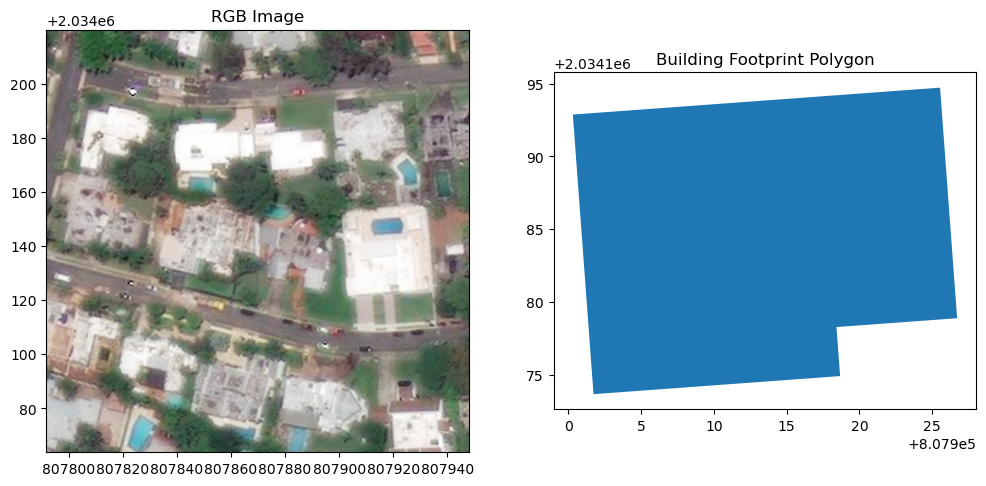

In [38]:
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gdp

image_path = np.random.choice(list(results_pre.keys()))
info = results_pre[image_path] #extract the associated building footprint
print(image_path , " : ", info)

with rasterio.open(image_path) as src:
        # Get the CRS (Coordinate Reference System) of the TIFF image
        crs = src.crs
        polygons = gdp.GeoDataFrame(geometry = info) 
        polygons = polygons.to_crs(crs)
        # Create subplot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

        # Plot RGB image
        show(src, ax=ax1)
        ax1.set_title('RGB Image')
        
        # Plot building footprint
        polygons.plot(ax=ax2)
        ax2.set_title('Building Footprint Polygon')

        plt.show()


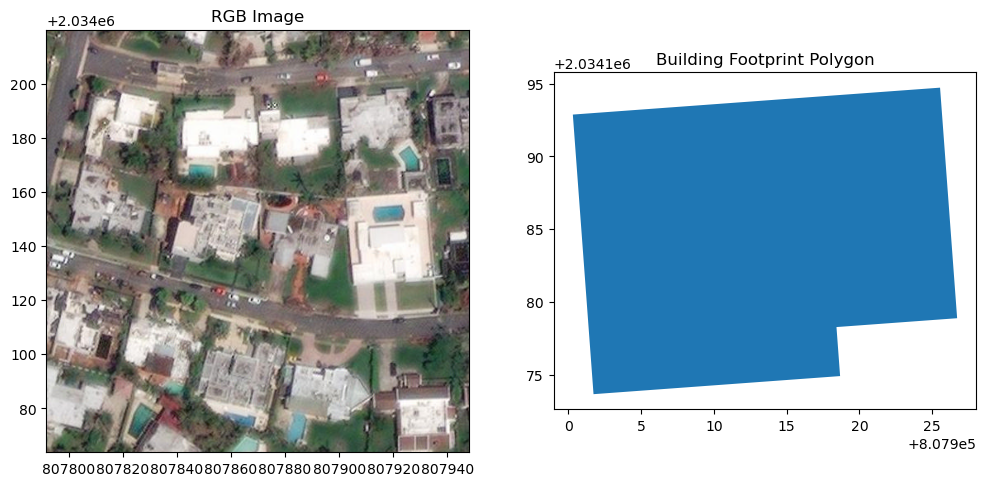

In [39]:

image_path = "Post_Event_Grids_In_TIFF/tile_71_73.tif"
with rasterio.open(image_path) as src:
        # Get the CRS (Coordinate Reference System) of the TIFF image
        crs = src.crs
        polygons = gdp.GeoDataFrame(geometry = info) 
        polygons = polygons.to_crs(crs)
        # Create subplot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

        # Plot RGB image
        show(src, ax=ax1)
        ax1.set_title('RGB Image')
        
        # Plot building footprint
        polygons.plot(ax=ax2)
        ax2.set_title('Building Footprint Polygon')

        plt.show()


### Display RGB image with Building Footprint

[[18.374265, -66.08734], [18.375698, -66.085839]]



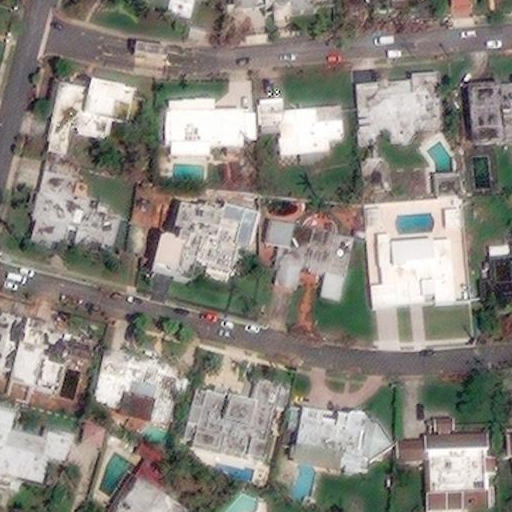

In [40]:
geom , bounds = extract_coor_from_tiff_image(image_path)
print(bounds)
polygons_ = info

# Filter out empty or missing polygons
valid_polygons = [polygon for polygon in polygons_ if not polygon.is_empty]

# Create the map
m = folium.Map(location=bounds[0], zoom_start=15)

# Add valid polygons to the map
bbox = folium.GeoJson(
    data={"type": "FeatureCollection", "features": [
        {"type": "Feature", "geometry": shapely.geometry.mapping(polygon)} for polygon in valid_polygons
    ]},
    style_function=lambda x: {'color': 'blue'}
).add_to(m)

# Add the image overlay
img = folium.raster_layers.ImageOverlay(
    name="pre event Puerto Rico",
    bounds=bounds,
    image=convert_tiff_to_numpy(image_path),
    opacity=1,
    cross_origin=False,
    zindex=1
).add_to(m)

# Add a popup
folium.Popup("pre event Puerto Rico").add_to(m)

# Show the map
m


In [57]:
from shapely.ops import cascaded_union
from rasterio.plot import reshape_as_image
from rasterio import features
import re 

#Generate polygon
def poly_from_utm(polygon, transform):
    poly_pts = []

    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):

        # Convert polygons to the image CRS
        poly_pts.append(~transform * tuple(i))

    # Generate a polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

    
def generate_mask(image_path, shapes, save_path_o):
    """
    image_path : string 
    shapes : list of polygones associated to image_path 
    """ 

    if not os.path.exists(save_path_o):
        os.makedirs(save_path_o)

    with rasterio.open(image_path, "r") as src: #read tiff image

        raster_image = src.read()
        raster_meta = src.meta
        crs_image = raster_meta["crs"]

    train_df = gpd.GeoDataFrame(geometry = shapes).to_crs(crs_image) #create a geo pandas with the footprints 

    poly_shp = []
    im_size = (src.meta['height'], src.meta['width'])
    for num, row in train_df.iterrows():
        if row['geometry'].geom_type == 'Polygon':
            poly = poly_from_utm(row['geometry'], src.meta['transform'])
            poly_shp.append((poly, num))
        else:
            for p in row['geometry']:
                poly = poly_from_utm(p, src.meta['transform'])
                poly_shp.append((poly,num))
    
    #create a mask from the footprint
    mask = features.rasterize(shapes=poly_shp,
                     out_shape=im_size, 
                     fill = -1,
                     
                    )

    """# Create subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

    # Plot RGB image
    ax1.imshow(image.read().transpose(1, 2, 0))
    ax1.set_title('RGB Image')

    # Plot building footprint
    ax2.imshow(mask)
    ax2.set_title('Building Footprint Mask')

    plt.show();
    """

    delimiters = "/. "
    mask = mask.astype("uint16")

    save_path = save_path_o + "/" + re.split('[{}]+'.format(''.join(map(re.escape, delimiters))), image_path)[1] + "_mask.tif"
    bin_mask_meta = src.meta.copy()
    bin_mask_meta.update({'count': 1})
    with rasterio.open(save_path, 'w', **bin_mask_meta) as dst:
        dst.write(mask * 255, 1)


In [ ]:
%%time
#converting tiff images into JPEG images
convert_tiff_to_jpeg(input_dir = "Pre_Event_Grids_In_TIFF", output_dir = "Pre_Event_Grids_In_jpeg")

In [ ]:
convert_tiff_to_jpeg(input_dir = "Post_Event_Grids_In_TIFF", output_dir = "Post_Event_Grids_In_jpeg")

In [256]:
convert_tiff_to_jpeg(input_dir = "Pre_Event_Grids_In_TIFF_mask",output_dir="Pre_Event_Grids_In_TIFF_mask_jpeg")

Conversion from TIFF to JPEG completed.


In [47]:
def convert_tiff_images_to_jpeg(image_paths_tiff, output_dir="Pre_Event_Grids_In_jpeg"):
    # check if output_dir exists, if not create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in tqdm(image_paths_tiff):
        # check if file is an image (ends with .tif)
        if filename.endswith('.tif'):
            img = Image.open(os.path.join(filename))
        
            # check if image is RGB mode, if not convert it
            if img.mode != 'RGB':
                img = img.convert('RGB')
        
            # create new filename, replace .tif with .jpg
            delimiters = "/. "
            output_filename = re.split('[{}]+'.format(''.join(map(re.escape, delimiters))), filename)[1] + '.jpg'
        
            # save the image in JPEG format
            img.save(os.path.join(output_dir, output_filename), 'JPEG', quality=100)
    print("Conversion from TIFF to JPEG completed.")

In [48]:
#converting the selected images to JPEG format 
convert_tiff_images_to_jpeg(results_pre.keys(),"Pre_Event_Grids_In_jpeg") 

100%|██████████| 4855/4855 [02:00<00:00, 40.37it/s]

Conversion from TIFF to JPEG completed.


In [49]:
#converting the selected images to JPEG format 
convert_tiff_images_to_jpeg(results_post.keys(),"Post_Event_Grids_In_jpeg") 

100%|██████████| 4855/4855 [04:08<00:00, 19.57it/s]

Conversion from TIFF to JPEG completed.


In [58]:
#generate the masks
save_path_o = "Pre_Event_Grids_In_TIFF_mask" # "Post_Event_Grids_In_TIFF_mask"

for image_path in tqdm(results_pre.keys()):
    generate_mask(image_path, results_pre[image_path], save_path_o)

100%|██████████| 4855/4855 [04:45<00:00, 17.01it/s]


In [59]:
save_path_o = "Post_Event_Grids_In_TIFF_mask"

for image_path in tqdm(results_post.keys()):
    generate_mask(image_path, results_post[image_path], save_path_o)


 12%|█▏        | 576/4855 [00:33<04:31, 15.79it/s]

100%|██████████| 4855/4855 [04:57<00:00, 16.30it/s]


### Converting 

In [60]:
convert_tiff_to_jpeg(input_dir="Pre_Event_Grids_In_TIFF_mask",output_dir="Pre_Event_Grids_mask_jpeg")

Conversion from TIFF to JPEG completed.


In [61]:
convert_tiff_to_jpeg(input_dir="Post_Event_Grids_In_TIFF_mask",output_dir="Post_Event_Grids_mask_jpeg")

Conversion from TIFF to JPEG completed.


Compressing mask folder is not mandatory

In [3]:
import shutil

# Specify the directory you want to zip
dir_name = 'Pre_Event_Grids_In_TIFF_mask_jpeg'

# Create a zip archive
output_filename = 'Pre_Event_Grids_In_TIFF_mask_jpeg'
shutil.make_archive(output_filename, 'zip', dir_name)

'/home/jovyan/Pre_Event_Grids_In_TIFF_mask_jpeg.zip'

In [4]:
# Specify the directory you want to zip
dir_name = 'Post_Event_Grids_In_TIFF_jpeg'

# Create a zip archive
output_filename = 'Post_Event_Grids_In_TIFF_jpeg'
shutil.make_archive(output_filename, 'zip', dir_name)

'/home/jovyan/Pre_Event_Grids_In_TIFF_jpeg.zip'